In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils

2021-12-19 10:54:48.641012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/qiu/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-19 10:54:48.641033: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'agnes_skinner', 2: 'apu_nahasapeemapetilon', 
        3: 'barney_gumble', 4: 'bart_simpson', 5: 'brandine_spuckler', 6: 'carl_carlson', 
        7: 'charles_montgomery_burns', 8: 'chief_wiggum', 9: 'cletus_spuckler', 10: 'comic_book_guy', 
        11: 'disco_stu', 12: 'dolph_starbeam', 13: 'duff_man', 
        14: 'edna_krabappel', 15: 'fat_tony', 16: 'gary_chalmers', 17: 'gil',18: 'groundskeeper_willie' , 19: 'homer_simpson', 
                  20: 'jimbo_jones'
                 , 21: 'kearney_zzyzwicz', 22: 'kent_brockman', 23: 'krusty_the_clown', 24: 'lenny_leonard', 25: 'lionel_hutz'
                  , 26: 'lisa_simpson', 27: 'lunchlady_doris',28:'maggie_simpson',29:'marge_simpson',30:'martin_prince'
                  ,31:'mayor_quimby',32:'milhouse_van_houten'
                  ,33:'miss_hoover',34:'moe_szyslak'
                 ,35:'ned_flanders',36:'nelson_muntz',37:'otto_mann',38:'patty_bouvier',39:'principal_skinner'
                 ,40:'professor_john_frink',41:'rainier_wolfcastle',42:'ralph_wiggum',43:'selma_bouvier',44:'sideshow_bob'
                 ,45:'sideshow_mel',46:'snake_jailbird',47:'timothy_lovejoy',48:'troy_mcclure'
                   ,49:'waylon_smithers'}

img_width = 42 
img_height = 42


num_classes = len(map_characters) # 要辨識的角色種類

pictures_per_class = 2100 # 每個角色會有接近1000張訓練圖像
test_size = 0.15

imgsPath = "/home/qiu/study_college/machine_learning/Simpsons/machine-learningntut-2021-autumn-classification/theSimpsons-train/train"3

In [3]:
def load_pictures():
    pics = []
    labels = []
    
    for k, v in map_characters.items(): # k: 數字編碼 v: 角色label
        # 把某一個角色在檔案夾裡的所有圖像檔的路徑捉出來
        pictures = [k for k in glob.glob(imgsPath + "/" + v + "/*")]        
        print(v + " : " + str(len(pictures))) # 看一下每個角色有多少訓練圖像
        for i, pic in enumerate(pictures):
            tmp_img = cv2.imread(pic)
            
            # 由於OpenCv讀圖像時是以BGR (Blue-Green-Red), 我們把它轉置成RGB (Red-Green-Blue)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            tmp_img = cv2.resize(tmp_img, (img_height, img_width)) # 進行大小歸一位            
            pics.append(tmp_img)
            labels.append(k)    
    return np.array(pics), np.array(labels)

# 取得訓練資料集與驗證資料集
def get_dataset(save=False, load=False):
    if load: 
        # 從檔案系統中載入之前處理保存的訓練資料集與驗證資料集
        h5f = h5py.File('dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()
        
        # 從檔案系統中載入之前處理保存的訓練資料標籤與驗證資料集籤
        h5f = h5py.File('labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    else:
        # 從最原始的圖像檔案開始處理
        X, y = load_pictures()
        y = np_utils.to_categorical(y, num_classes) # 目標的類別種類數
        
        # 將資料切分為訓練資料集與驗證資料集 (85% vs. 15%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        if save: # 保存尚未進行歸一化的圖像數據
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()
            
            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
    
    # 進行圖像每個像素值的型別轉換與歸一化處理
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test   

In [4]:
# 取得訓練資料集與驗證資料集  
X_train, X_test, y_train, y_test = get_dataset(save=True, load=False)

abraham_grampa_simpson : 2067
agnes_skinner : 1866
apu_nahasapeemapetilon : 2044
barney_gumble : 1926
bart_simpson : 2026
brandine_spuckler : 1868
carl_carlson : 1897
charles_montgomery_burns : 2011
chief_wiggum : 2067
cletus_spuckler : 1901
comic_book_guy : 2008
disco_stu : 1877
dolph_starbeam : 1863
duff_man : 1880
edna_krabappel : 1960
fat_tony : 1855
gary_chalmers : 1897
gil : 1896
groundskeeper_willie : 1879
homer_simpson : 2067
jimbo_jones : 1862
kearney_zzyzwicz : 1876
kent_brockman : 2016
krusty_the_clown : 2023
lenny_leonard : 1955
lionel_hutz : 1940
lisa_simpson : 2039
lunchlady_doris : 1851
maggie_simpson : 1914
marge_simpson : 2025
martin_prince : 1889
mayor_quimby : 1926
milhouse_van_houten : 2067
miss_hoover : 1881
moe_szyslak : 2035
ned_flanders : 2034
nelson_muntz : 1941
otto_mann : 1857
patty_bouvier : 1879
principal_skinner : 2014
professor_john_frink : 1872
rainier_wolfcastle : 1905
ralph_wiggum : 1865
selma_bouvier : 1880
sideshow_bob : 2067
sideshow_mel : 1875
snak

In [1]:
def create_model_six_conv(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;

In [11]:
model = create_model_six_conv((img_height, img_width, 3)) # 初始化一個模型
model.summary() # 秀出模型架構

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 42, 42, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 20, 20, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 18, 64)        36928     
                                                      

In [12]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

/home/qiu/miniconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [24]:
def lr_schedule(epoch):
    return lr
#*(0.1**int(epoch/10))

batch_size = 128
epochs = 250

history = model.fit(X_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_test, y_test),
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', save_best_only=True)
         ])

2021-12-19 19:04:03.809925: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1744010352 exceeds 10% of free system memory.


Epoch 1/50
644/644 [==============================] - 117s 181ms/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 0.1847 - val_accuracy: 0.9596 - lr: 0.0100
Epoch 2/50
644/644 [==============================] - 116s 180ms/step - loss: 0.0535 - accuracy: 0.9844 - val_loss: 0.1680 - val_accuracy: 0.9642 - lr: 0.0100
Epoch 3/50
644/644 [==============================] - 116s 179ms/step - loss: 0.0592 - accuracy: 0.9824 - val_loss: 0.1725 - val_accuracy: 0.9650 - lr: 0.0100
Epoch 4/50
644/644 [==============================] - 117s 182ms/step - loss: 0.0540 - accuracy: 0.9840 - val_loss: 0.1606 - val_accuracy: 0.9660 - lr: 0.0100
Epoch 5/50
644/644 [==============================] - 117s 181ms/step - loss: 0.0587 - accuracy: 0.9833 - val_loss: 0.1626 - val_accuracy: 0.9653 - lr: 0.0100
Epoch 6/50
644/644 [==============================] - 118s 183ms/step - loss: 0.0527 - accuracy: 0.9848 - val_loss: 0.1635 - val_accuracy: 0.9662 - lr: 0.0100
Epoch 7/50
644/644 [==========================

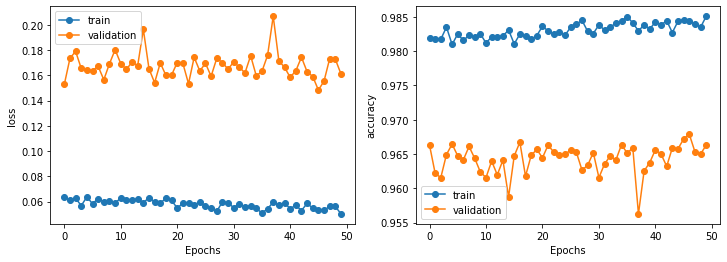

In [22]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'accuracy','val_accuracy')

plt.show()

In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen = datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# 保存在訓練過程中比較好的模型
filepath="model-dtaug.h5"

# 保留"val_acc"最好的那個模型
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

# 定義學習率遞減的原則
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

#圖像的shape是 (42,42,3)
model = create_model_six_conv((img_height, img_width, 3)) # 初始化一個模型

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks=callbacks_list)

/tmp/ipykernel_20496/3096360109.py:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/30
2574/2574 [==============================] - 120s 47ms/step - loss: 3.3224 - accuracy: 0.1365 - val_loss: 2.3523 - val_accuracy: 0.3657 - lr: 0.0100
Epoch 2/30
2574/2574 [==============================] - 120s 47ms/step - loss: 2.0073 - accuracy: 0.4579 - val_loss: 1.2518 - val_accuracy: 0.6539 - lr: 0.0100
Epoch 3/30
2574/2574 [==============================] - 120s 47ms/step - loss: 1.4180 - accuracy: 0.6187 - val_loss: 0.9117 - val_accuracy: 0.7485 - lr: 0.0100
Epoch 4/30
2574/2574 [==============================] - 120s 47ms/step - loss: 1.1872 - accuracy: 0.6807 - val_loss: 0.7940 - val_accuracy: 0.7846 - lr: 0.0100
Epoch 5/30
2574/2574 [==============================] - 121s 47ms/step - loss: 1.0738 - accuracy: 0.7135 - val_loss: 0.6957 - val_accuracy: 0.8092 - lr: 0.0100
Epoch 6/30
2574/2574 [==============================] - 126s 49ms/step - loss: 1.0118 - accuracy: 0.7280 - val_loss: 0.7512 - val_accuracy: 0.7987 - lr: 0.0100
Epoch 7/30
2574/2574 [==================

In [25]:
# 預測與比對
from keras.models import load_model
def read_images(path):
    images=[]
    for i in range(10791):
        image = cv2.resize(cv2.imread(path+str(i+1)+'.jpg'),(img_height,img_width))
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        images.append(image)
    images = np.array(images,dtype = np.float32)/255
    return images
    
imgsPath = "/home/qiu/study_college/machine_learning/Simpsons/machine-learningntut-2021-autumn-classification/theSimpsons-test/test/"    
# 把訓練時val_loss最小的模型載入
#model = load_model('model-dtaug.h5')
model = load_model('model.h5')

test_images=read_images(imgsPath)
pred =model.predict(test_images)
pred = np.argmax(pred,axis = 1)
with open('keras6.csv','w')as f:
                            f.write('id,character\n')
                            for i in range(len(pred)):
                                    f.write(str(i+1)+','+map_characters[pred[i]]+'\n')